In [1]:
import time
import networkx
import numpy as np
import scipy
from scipy.optimize import linear_sum_assignment
import cv2

In [2]:
def compute_alpha(M, delta_f, D, adjacency1, adjacency2, K=0, lamb=1):
    tr_matrix1 = tr_dot(M.T, delta_f)
    tr_matrix2 = tr_dot(delta_f, D.T)
    tr_matrix3 = tr_matrix2
    tr_matrix4 = tr_dot(D.T * adjacency1, D * adjacency2)
    
    if np.max(K) == 0:
        tr_matrix5 = 0
        tr_matrix6 = 0
    else:

        tr_matrix5 = tr_dot(D.T, K)
        tr_matrix6 = tr_dot(M.T, K)

    tr_matrix1m2m3 = tr_matrix1 - tr_matrix2 - tr_matrix3
    alpha_a = tr_matrix1m2m3 + tr_matrix4
    alpha_b = -tr_matrix1m2m3 - tr_matrix1 + lamb * tr_matrix5 - lamb * tr_matrix6
    alpha_op = -alpha_b / (2 * alpha_a)
    return alpha_op

def tr_dot(a, b):
    # Compute np.trace(a*b)
    trace = np.sum(np.multiply(a, b.T))  # 
    return trace

def hugarian(matrix):
    n, m = matrix.shape
    P = np.mat(np.zeros((n, m)))
    row_ind, col_ind = linear_sum_assignment(-matrix)
    P[row_ind, col_ind] = 1
    return P

In [12]:
def graphmatch_ASM(
    adjacency1, adjacency2, K=0, tol=0.1, alpha=1, lamb=1, gamma0=5, adaptive_alpha=0,niter_max=30 
):
    '''
    Find correspondence for pairwise graphs
    
    Input  
    adjacency1/adjacency2:  adjacency matrices for two graphs
    K: product of two feature matrices
    
    Output
    M: Matching matrix
    runtime: Running time
    '''
    starttime = time.perf_counter()
    n, _ = adjacency1.shape
    m, _ = adjacency2.shape
    big_nm = max(n, m)
    N = np.mat(np.ones((n, m))) / n 
    D = np.mat(np.zeros((big_nm, big_nm)))
    gamma = gamma0

    for i in range(niter_max):
        
        N0 = N
        delta_edges = adjacency1 * N * adjacency2
        D[0:n, 0:m] = delta_edges + lamb * K
        gamma = max(gamma -5, gamma0)
        D, gamma = adaptive_softassign(D, gamma)
        
        if adaptive_alpha: # Compute optimal alpha
            alpha = compute_alpha(N0, delta_edges, D[0:n, 0:m], adjacency1, adjacency2, K, lamb)
            if alpha >= 0 and alpha < 1:
                print("Alpha is" + str(alpha_op))
            else:
                alpha = 1
            
            
        N = (1 - alpha) * N + alpha * D[0:n, 0:m]

        err = abs(N0 / N0.max() - N / N.max()).max()
        print(i, err)
        if err < tol:
            print("Converge")
            break
    M = hugarian(N)
    endtime = time.perf_counter()
    runtime = endtime - starttime
    return M, runtime



def softassign(X, gamma=1):
    # Exponentiate the protfit matrix X to create J
    n, m = X.shape
    X = X/X.max() 
    beta = np.log((n + m) / 2) * gamma  #
    J = np.exp(beta *(X))
    # Sinkhorn
    S = sinkhorn(J)
    return S


def sinkhorn(M, num_iters=1000,tol=0.05):
    M = np.array(M)
    n, m = M.shape

    # Initialize the scaling factors u and v
    u, v = np.ones(n), np.ones(m) 

    # Run Sinkhorn iterations
    for i in range(num_iters):
        u_new = 1 / np.matmul(M, v)  #Sum of row 
        v_new = 1 / np.matmul(M.T, u_new) #Sum of clo

        if i % 5 ==1: # Stopping test
            res_diff =  np.max(np.abs(u-u_new))
            if res_diff<tol:
                u, v = u_new, v_new 
                break
        
        u, v = u_new, v_new 

    project_matrix = np.outer(u_new,v_new)
    S = np.multiply(project_matrix, M)
    S = np.mat(S)
    return S

def adaptive_softassign(matrix, gamma_ini=1, eps=0.05):
    matrix = np.array(matrix)
    diff = 10
    Ms0 = softassign(matrix, gamma_ini)
    while diff > eps:
        Ms = np.power(Ms0, ((gamma_ini + 1) / gamma_ini))
        Ms = sinkhorn(Ms)
        diff = np.linalg.norm(Ms - Ms0, 1)
        Ms0 = Ms
        gamma_ini += 1
    Ms = np.mat(Ms)
    return Ms, gamma_ini

# Protein network

In [4]:
nosiy5_graph = networkx.read_leda("networks/networks/synthetic_nets_known_node_mapping/low_confidence/0Krogan_2007_high+25e.gw")
sorce_graph = networkx.read_leda("networks/networks/synthetic_nets_known_node_mapping/0Krogan_2007_high.gw")
adj_noisy5 = networkx.to_numpy_matrix(nosiy5_graph)
adj_sorce = networkx.to_numpy_matrix(sorce_graph)

In [13]:
M, runtime = graphmatch_ASM(adj_noisy5, adj_sorce,adaptive_alpha=1,niter_max=40,tol=0.1)

0 1.0
1 0.7963062986374727
2 0.8126700116805644
3 0.9547541097139969
4 0.8605844334879016
5 0.7177059575306827
6 0.5946441226673429
7 0.46021639743766096
8 0.6725531947802691
9 0.4377136352850287
10 0.3961992596564944
11 0.33298941728368536
12 0.2924898720152861
13 0.28196169581352903
14 0.15350198851465474
15 0.13777607887834264
16 0.22093899808907552
17 0.24365150432630078
18 0.13055784638005036
19 0.12945779968735205
20 0.12326053572002155
21 0.10565180634160609
22 0.106446690035719
23 0.09233864796962343
Converge


In [14]:
print('Running time is '+ str(runtime)+ 's')
Accuracy = sum(np.diag(M))/1004 # The correct matching matrix is Identity matrix and number of nodes is 1004
print('Accuracy is '+ str(Accuracy)) 

Running time is 26.738145000000003s
Accuracy is 0.75199203187251


# Matching on real image
In this set of experiments,weighted graphs were constructed from images. SIFT(Scale-invariant feature transform) feature descriptor is applied to images. Nodes are selected from key points and edges represent Euclidean distance between nodes.

In [32]:
img1 = cv2.imread("networks/img1.jpg")
img2 = cv2.imread("networks/img2.jpg")
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
lenth, wide=gray1.shape

## Extract key points

In [33]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=1000) 
kp1, des1 = sift.detectAndCompute(gray1,None)
kp2, des2 = sift.detectAndCompute(gray2,None)

future1=np.mat(des1)
future2=np.mat(des2)

In [34]:
# The key points in picture

# img_with_keypoints = cv2.drawKeypoints(img1, kp1, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# cv2.imshow('Image with SIFT Keypoints', img_with_keypoints)
# cv2.waitKey(0)  # Click 'space bar' to close the picture
# cv2.destroyAllWindows() 

## Construct  adjacency matrices

In [35]:
def coordinate(point):
    coordinates=np.mat(np.zeros((len(point),2)))
    for i in range(len(point)):   # range(i)=range(0,i)=[0,i)
        for j in range(2):
            coordinates[i, j] = point[i].pt[j]
    return coordinates


def EuclidMatrix(coordinates):
    n = coordinates.shape[0]
    edge = np.mat(np.zeros((n, n)))
    for i in range(n):
        for j in range(i + 1, n):
            diffe = coordinates[i] - coordinates[j]
            edge[i, j] = np.sqrt(np.sum(np.multiply(diffe, diffe)))
            #linalg.norm(diffe,ord=2)
            edge[j, i] = edge[i, j]
    return edge

In [36]:
coordinates1=coordinate(kp1)
coordinates2=coordinate(kp2)
adjacency1= EuclidMatrix(coordinates1)
adjacency2= EuclidMatrix(coordinates2)

## Select nodes 

In [41]:
def get_index(Feature,counterFeature,numFeature=500):
    similarityList=[]
    indexList=[]
    for i in range(len(Feature)):
        iSimilaty=np.sum(Feature[i]*counterFeature)# ith feature similarity
        similarityList.append([i,iSimilaty]) # (index,similarity)
    similarityList=sorted(similarityList, key = lambda x:x[1],reverse =True)  #Sorting according similarities
    for i in range(numFeature):
        indexList.append(similarityList[i][0]) #indexList 
    return indexList

def get_kp(index_list,kp):
    new_kp=[]
    for i in index_list:
        new_kp.append(kp[i])
    return new_kp

def get_adjacency(index_list,adjacency):
    row_adjacency=adjacency[index_list]
    new_adjacency=row_adjacency[:,index_list]
    return new_adjacency


def select_feature(des1,des2,kp1,kp2,adjacency1,adjacency2,nfeature=500):
    index_list1=get_index(Feature=des1,counterFeature=des2,numFeature=nfeature)
    sel_future1=np.mat(des1[index_list1])
    sel_kp1=get_kp(index_list1,kp1)
    sel_adjacency1=get_adjacency(index_list1,adjacency1)

    index_list2=get_index(Feature=des2,counterFeature=des1,numFeature=nfeature)
    sel_future2=np.mat(des2[index_list2])
    sel_kp2=get_kp(index_list2,kp2)
    sel_adjacency2=get_adjacency(index_list2,adjacency2)
    return sel_future1,sel_future2,sel_kp1,sel_kp2,sel_adjacency1,sel_adjacency2

In [42]:
numNodes = 1000

sel_F1,sel_F2,sel_kp1,sel_kp2,sel_A1,sel_A2=select_feature(des1,
                                                           des2,
                                                           kp1,
                                                           kp2,
                                                           adjacency1,
                                                           adjacency2,
                                                           numNodes)
K=sel_F1 * np.transpose(sel_F2)

## Matching

In [43]:
M, runtime = graphmatch_ASM(sel_A1, sel_A2,  K)

0 0.9999999944149042
1 0.1422103094230781
2 0.8941818493453594
3 0.34791040965606557
4 0.07687382210973104
Converge


In [44]:
print('Running time is '+ str(runtime)+ 's')

Running time is 4.384580599999936s


## Error evaluation

$$\frac{1}{4}\|A − M\tilde{A}M^T\|_F^{2}+  \|F − M\tilde{F}^T\|_F^{2}$$

where $\small{\|\|_F^{2}}$ is the Frobenius matrix norm.

The left term can be interpreted as dissimilarity between edges 

The right term as dissimilarity between nodes.

In [45]:
def evaluation(M, adjacency1, adjacency2, future1=0, future2=0):
    dissimilarEdges = adjacency1 - M * adjacency2 * M.T
    errorEdge = np.linalg.norm(dissimilarEdges)/4
    errorNode = np.linalg.norm(future1-M*future2)
    totalError = errorEdge + errorNode
    print(totalError)
    return totalError

In [46]:
evaluation(M,sel_A1, sel_A2,sel_F1,sel_F2)

17705.09524503469


17705.09524503469

## Visualization of the matching

In [47]:
def macthingShow(P, img1, img2, kp1, kp2, show_rate=1,color=(0,255,255),thick=2, linetype=4):

    pair = np.where(P == 1)  # Size is  (2 , min(n,m)). First row is indexes of nodes of Graph1
    n, m = P.shape
    matchNum = min(n, m)  # min(n,m) matching
    row1, col1, _ = img1.shape
    row2, col2, _ = img2.shape
    out = np.zeros((np.max([row1, row2]), col1 + col2, 3), dtype='uint8')
    out[:row1, :col1] = img1
    out[:row2, col1:] = img2
    coordinates1=coordinate(kp1)
    coordinates2=coordinate(kp2)

    for i in range(matchNum):
        pointA = coordinates1[pair[0][i]]
        pointB = coordinates2[pair[1][i]] + [col1, 0]
        pointa = (int(pointA[0, 0]), int(pointA[0, 1]))
        pointb = (int(pointB[0, 0]), int(pointB[0, 1]))

        if i%(int(1/show_rate))==1 or show_rate==1:      
            cv2.line(out, pointa, pointb, color, thickness=thick, lineType=linetype, shift=0)#(a, b, c)

    plt.imshow(out)
    plt.show()
    return out

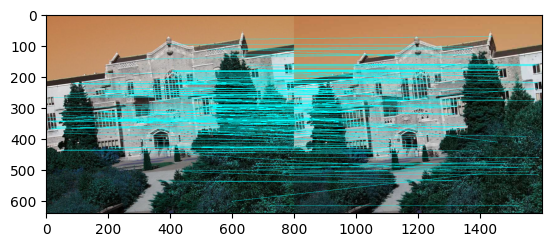

In [48]:
from matplotlib import pyplot as plt

matching_pic=macthingShow(M, img1, img2, 
                                  sel_kp1, sel_kp2, show_rate=0.2,
                                  color=(0,255,255),thick=1, linetype=4)